# What is a Sklearn Pipeline? 2 Examples in Python

In this notebook, I will cover scikit-learn pipelines. The purpose of this notebook is to illustrate why it is a good idea to include pipelines in a machine learning project, and how you can do so.

Pipelines provide a means by which data-processing code can be organised in a project. These consist of a sequential list of transformers, with an estimator at the end of the sequence. Each transformer must include 'fit' and 'transform' methods, whereas the final estimator only needs a 'fit' method.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)

## Example 1

Let's construct a simple dataset we can make use of, and then apply a series of transformers to the data with a final estimator.

In [2]:
# build a toy dataset with numeric predictor features
X,y = make_classification(n_samples=10000, 
                          n_features=20, 
                          n_informative=10, 
                          n_redundant=5, 
                          shift=10, 
                          scale=5, 
                          random_state=42)

In [3]:
# do train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# assemble a pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('pca', PCA(n_components=10)), 
                       ('lr', LogisticRegression())])

In [5]:
# train the pipeline and test the result
pipe.fit(X_train, y_train)
# produce predictions
y_pred = pipe.predict(X_test)

In [6]:
# display resulting metrics
print(f"accuracy: {accuracy_score(y_test,y_pred):.2f}")
print(f"precision: {precision_score(y_test,y_pred):.2f}") 
print(f"recall: {recall_score(y_test,y_pred):.2f}")
print(f"f1: {f1_score(y_test,y_pred):.2f}")

accuracy: 0.81
precision: 0.81
recall: 0.78
f1: 0.80


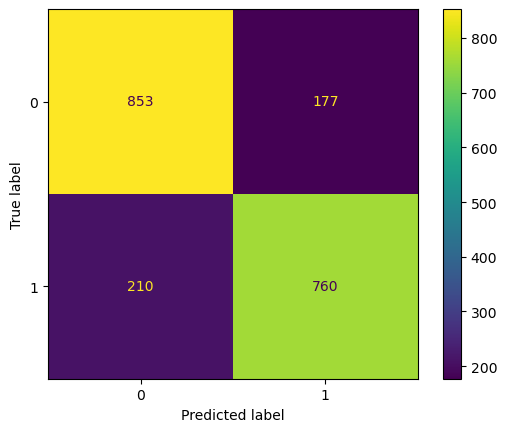

In [7]:
# display a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

We can see that our pipeline is working, and we get some nice results! Let's now move on to our second example...

## Example 2

Let's add an additional predictive feature to our dataset, that will be categorical in nature: 

In [8]:
# create new categorical column & add it to the list of predictors
dfX = pd.DataFrame(X, columns = [f"col_{i+1}" for i in range(X.shape[1])])
dfX[f"col_{X.shape[1]+1}"] = np.where(y == 0, "red", "blue").reshape(-1,1)

In [9]:
dfX.head(5)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,58.584044,52.067364,44.286444,29.668701,54.692255,50.194197,27.295917,43.726045,49.030151,46.556252,...,53.501270,49.318032,53.465520,55.884285,63.038168,42.789004,51.850297,52.052089,56.966599,red
1,43.155229,55.558848,64.347381,37.509342,44.399732,53.772581,43.661497,66.727674,53.747941,50.840828,...,45.161063,41.094080,64.979548,38.044689,58.023225,33.330973,52.820739,48.693852,54.066125,red
2,53.796561,47.446331,38.047910,62.049478,57.506958,45.630952,17.519921,54.343029,53.078513,41.806291,...,51.693418,44.976918,55.172328,46.111035,51.421137,50.900929,47.107519,76.028824,20.718042,blue
3,44.954812,47.595999,51.577698,52.230242,44.275950,47.971451,52.896253,54.283889,48.218078,50.984722,...,53.903390,46.207899,63.544992,61.317802,31.083178,35.764121,70.782798,37.268595,74.211729,red
4,34.113668,48.994326,69.724700,50.176694,64.372031,49.270625,46.617304,46.896209,43.257541,49.834789,...,47.299368,34.168186,40.431245,47.349832,52.196725,51.815421,37.712093,49.870919,37.415112,blue


We'll now need to create a new transformer, that will be capable of handling the new column.

In [10]:
class NewTransformer(BaseEstimator, TransformerMixin):
    """
    Class to handle revised dataset with a categorical feature with 2 unique values
    """
    def __init__(self) -> None:
        self.categorical_cols = []
        
    def fit(self, dfX: pd.DataFrame, y=None) -> None:
        """
        Fit method for our new transformer. 
        
        Inputs:
            dfX -> pandas dataframe of predictor features
            y -> numpy array of labels (not used)
        """
        for col in dfX.select_dtypes(['object']):
            self.categorical_cols.append(col)
            
        return self
            
    def transform(self, dfX: pd.DataFrame) -> np.array:
        """
        Transform method for our new transformer
        
        Input:
            dfX -> pandas dataframe of predictor features
        Output:
            numpy array of transformed values
        """
        return pd.get_dummies(dfX, 
                              columns=self.categorical_cols, 
                              drop_first=True).values

Now let's repeat the analysis done earlier, but with an additional stage in our pipeline to include the new transformer:

In [11]:
# do train-test split
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.2, random_state=42)

In [12]:
# assemble a pipeline
pipe = Pipeline(steps=[('ohe', NewTransformer()), 
                       ('scaler', StandardScaler()), 
                       ('pca', PCA(n_components=10)), 
                       ('lr', LogisticRegression())])

In [13]:
# train the pipeline and test the result
pipe.fit(X_train, y_train)
# produce predictions
y_pred = pipe.predict(X_test)

In [14]:
# display resulting metrics
print(f"accuracy: {accuracy_score(y_test,y_pred):.2f}")
print(f"precision: {precision_score(y_test,y_pred):.2f}") 
print(f"recall: {recall_score(y_test,y_pred):.2f}")
print(f"f1: {f1_score(y_test,y_pred):.2f}")

accuracy: 0.93
precision: 0.93
recall: 0.93
f1: 0.93


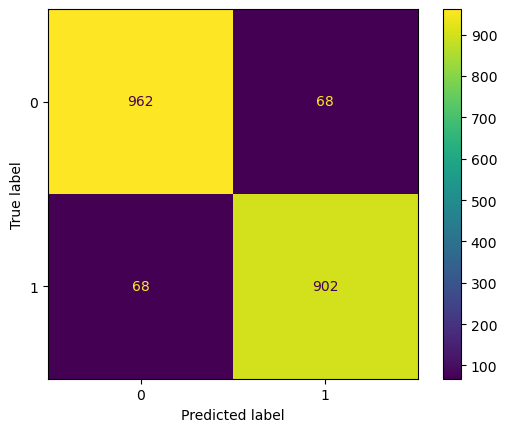

In [15]:
# display a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

We can see that the inclusion of the extra feature has dramatically improved the performance of our classifier. This shouldn't be too surprising: the categorical feature maps 1-to-1 to our label! Regardless of the outcome, this example illustrates how you can build your own custom transformers to use within a scikit-learn pipeline.